In [ ]:
# Install tensorflow 2.0 - restart the kernel if this is ran.
!pip install -q tensorflow==2.0.0-alpha0

In [75]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [76]:
# We'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## Preprocess the images using InceptionV3
Next, we will use InceptionV3 (pretrained on Imagenet) to classify each image. We will extract features from the last convolutional layer.

First, we will need to convert the images into the format inceptionV3 expects by: * Resizing the image to (299, 299) * Using the preprocess_input method to place the pixels in the range of -1 to 1 (to match the format of the images used to train InceptionV3).

In [77]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [78]:
# Help us download tokenizer and model files.
def downloadFile(downloadFilePath, localFilePath):
    fileExists = os.path.isfile(localFilePath)
    if not fileExists:
        !wget -O {localFilePath} {downloadFilePath}

### Initialize InceptionV3 and load the pretrained Imagenet weights
To do so, we'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. * Each image is forwarded through the network and the vector that we get at the end is stored in a dictionary (image_name --> feature_vector). * We use the last convolutional layer because we are using attention in this example. The shape of the output of this layer is 8x8x2048. * We avoid doing this during training so it does not become a bottleneck. * After all the images are passed through the network, we pickle the dictionary and save it to disk.



In [79]:
image_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [80]:
downloadFile('https://storage.googleapis.com/tf2-prebuilt--models/image_captioning/tokenizer.pickle',
            'tokenizer.pickle')

# load tokenizer from pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

--2019-04-02 10:55:17--  https://storage.googleapis.com/tf2-prebuilt--models/image_captioning/tokenizer.pickle
Resolving storage.googleapis.com... 172.217.9.16, 2607:f8b0:4000:812::2010
Connecting to storage.googleapis.com|172.217.9.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 959622 (937K) [application/octet-stream]
Saving to: ‘tokenizer.pickle’

tokenizer.pickle    100%[===================>] 937.13K  2.05MB/s    in 0.4s    

2019-04-02 10:55:18 (2.05 MB/s) - ‘tokenizer.pickle’ saved [959622/959622]



In [81]:
# The parameters we used during training

BATCH_SIZE = 128
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = 24009
# shape of the vector extracted from InceptionV3 is (64, 2048)
# these two variables represent that
features_shape = 2048
attention_features_shape = 64

### Model
Fun fact, the decoder below is identical to the one in the example for Neural Machine Translation with Attention.

The model architecture is inspired by the Show, Attend and Tell paper.

In this example, we extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
We squash that to a shape of (64, 2048).
This vector is then passed through the CNN Encoder(which consists of a single Fully connected layer).
The RNN(here GRU) attends over the image to predict the next word.

In [82]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    
    # attention_weights shape == (batch_size, 64, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [83]:
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [84]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.units)
        
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    
    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [85]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [86]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)


In [87]:
# Download checkpoint files
checkpoint_path = "./checkpoints/train"
if not os.path.exists(checkpoint_path):
    print('making dirs')
    os.makedirs(checkpoint_path)

downloadFile('https://storage.googleapis.com/tf2-prebuilt--models/image_captioning/checkpoint',
             checkpoint_path + '/checkpoint')
downloadFile('https://storage.googleapis.com/tf2-prebuilt--models/image_captioning/ckpt-2.data-00000-of-00001',
            checkpoint_path + '/ckpt-2.data-00000-of-00001')
downloadFile('https://storage.googleapis.com/tf2-prebuilt--models/image_captioning/ckpt-2.index',
            checkpoint_path + '/ckpt-2.index')

making dirs
--2019-04-02 10:55:26--  https://storage.googleapis.com/tf2-prebuilt--models/image_captioning/checkpoint
Resolving storage.googleapis.com... 172.217.9.16, 2607:f8b0:4000:812::2010
Connecting to storage.googleapis.com|172.217.9.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254 [application/octet-stream]
Saving to: ‘./checkpoints/train/checkpoint’

./checkpoints/train 100%[===================>]     254  --.-KB/s    in 0s      

2019-04-02 10:55:26 (17.3 MB/s) - ‘./checkpoints/train/checkpoint’ saved [254/254]

--2019-04-02 10:55:26--  https://storage.googleapis.com/tf2-prebuilt--models/image_captioning/ckpt-2.data-00000-of-00001
Resolving storage.googleapis.com... 172.217.9.16, 2607:f8b0:4000:812::2010
Connecting to storage.googleapis.com|172.217.9.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254662896 (243M) [application/octet-stream]
Saving to: ‘./checkpoints/train/ckpt-2.data-00000-of-00001’

./checkpoints/trai

In [88]:
ckpt = tf.train.Checkpoint(encoder=encoder, 
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [89]:
start_epoch = 0
print(ckpt_manager.latest_checkpoint)
if ckpt_manager.latest_checkpoint:
  print('latest checkpoint')
  status = ckpt.restore(tf.train.latest_checkpoint(checkpoint_path))
  #status.assert_consumed()  # Optional sanity checks.
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

./checkpoints/train/ckpt-2
latest checkpoint


In [90]:
def evaluate(image):
    max_length=52
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [91]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Prediction Caption: a man holding a cell phone <end>


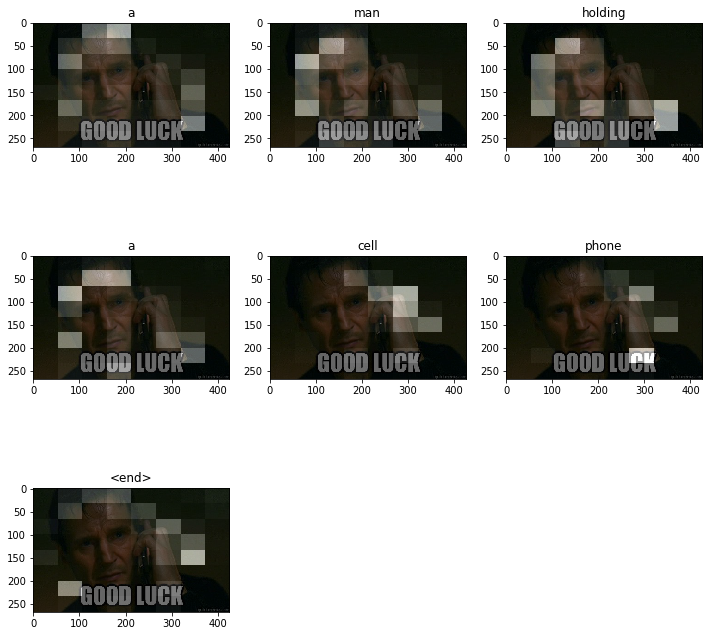

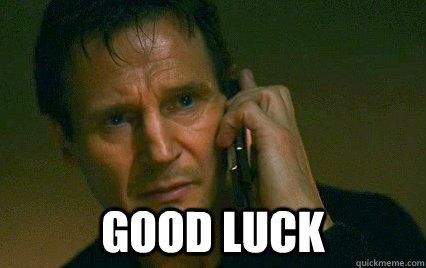

In [92]:
# captions on the validation set
image = 'img.jpg'
result, attention_plot = evaluate(image)

print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(image)